In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# What columns exist on each table?
inspector = inspect(engine)

meas_columns = inspector.get_columns('measurement')
print("Measurement")
for c in meas_columns:
    print(c['name'], c["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations")
for c in station_columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
## Calculate the date 1 year ago from the last data point in the database:

# get last date contained in the dataset for reference
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

# 2017 not a leap year so we can simply subtract 365 days (and keep just for date for cleanliness)
last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date from one year ago is: {last_year_date}")

Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
measurement_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*measurement_cols).\
            filter(Measurement.date >= last_year_date).all()
prcp_data[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [15]:
# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [ ]:
# Set the index to the date column and sort the dataframe by date
prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.sort_index()

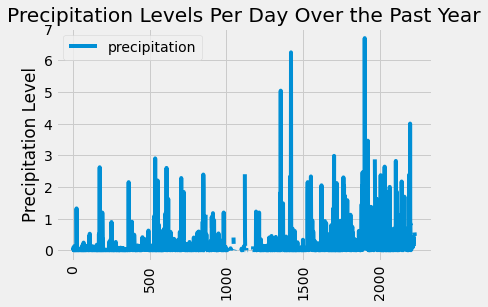

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90);
ax.set_title("Precipitation Levels Per Day Over the Past Year");
ax.set_ylabel("Precipitation Level");

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > last_year_date).all()
USC00519281_data[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

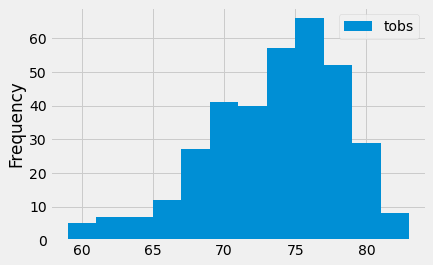

In [21]:
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist",bins=12);

Bonus Assignment:

Temperature Analysis I
Hawaii is known to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

You may either use SQLAlchemy or pandas's read_csv() to do this portion 

Try to Identify the average temperature in June at all stations across all available years in the dataset. Try to do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. See if you will use a paired t-test, or an unpaired t-test? 

In [22]:
# return the raw data from each month, June and December
june_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label them and then concatenate into one DataFrame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
december_df = pd.DataFrame(december_data,columns=["Date","Temperature"])
june_df["Month"] = "June"
december_df["Month"] = "December"
temp_df = pd.concat([june_df,december_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = temp_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

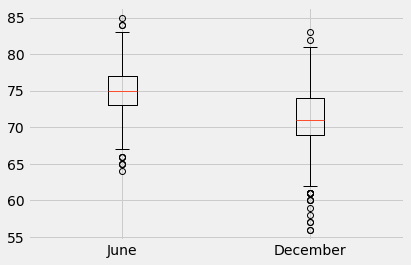

In [23]:
# We will use the t-test to determine if the average temperatures between June and December are statistically 
# significantly different. We will use the unpaired t-test because we are comparing means from separate groups 
# by month that are not dependent on each other

# H0: The difference between the mean temperatures of June and December is equal to zero
# H1: The difference between the mean temperatures of June and June and December is NOT equal to zero

box_data = [june_df["Temperature"],december_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temperature"], december_df["Temperature"])

Based on this boxplot it looks like there is overlap but since the p-value is less than 0.05, it shows that we can reject the null hypothesis which conclude that the difference in means is statistically significant also that there is a meaningful difference in temperature between June and December.

Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Let's choose the date range 4/10/2014-4/22/2014. That seems like a good amount of time for a trip to Hawaii!
trip_start_date = '2014-04-10'
trip_end_date = '2014-04-22'

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

def get_last_year_dates(start_date, end_date):
    """Calculates last year's start and end dates given the input start and end dates.
       This assumes no leap year (yet). 
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        last_year_start_date (string): A date string in the format %Y-%m-%d 365 days earlier than start_date
        last_year_end_date (string): A date string in the format %Y-%m-%d 365 days earlier than end_date
    """
    
    last_year_start_date = (dt.datetime.strptime(trip_start_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_end_date = (dt.datetime.strptime(trip_end_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_start_date, last_year_end_date

last_start_date, last_end_date = get_last_year_dates(trip_start_date, trip_end_date)

tmin, tavg, tmax = calc_temps(last_start_date,last_end_date)[0]
print(tmin, tavg, tmax)

63.0 72.47524752475248 81.0


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# (Note: Need to include columns from both tables in the join for SQLAlchemy before running or else get an error)
query_columns = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*query_columns).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= last_start_date).filter(Measurement.date <= last_end_date).\
                    order_by(func.sum(Measurement.tobs).desc()).all()
last_year_data

[('USC00519397', 'WAIKIKI 717.2, HI US', 966.0, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  948.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  926.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 924.0, 21.4234, -157.8015, 14.6),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  922.0,
  21.3152,
  -157.9992,
  0.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  920.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  905.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 669.0, 21.3934, -157.9751, 11.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  140.0,
  21.4992,
  -158.0111,
  306.6)]

In [29]:
pd.DataFrame(last_year_data,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)


,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",966.0,21.27160,-157.81680,3.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",948.0,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",926.0,21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",924.0,21.42340,-157.80150,14.6
4,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",922.0,21.31520,-157.99920,0.9
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",920.0,21.33310,-157.80250,152.4
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",905.0,21.52130,-157.83740,7.0
7,USC00517948,"PEARL CITY, HI US",669.0,21.39340,-157.97510,11.9
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",140.0,21.49920,-158.01110,306.6


Average Daily Rainfall

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"The trip dates are {trip_start_date} to {trip_end_date}")

The trip dates are 2014-04-10 to 2014-04-22


In [32]:
# Use the start and end date to create a range of dates
s_date = dt.datetime.strptime(trip_start_date,'%Y-%m-%d')
e_date = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') 
delta = e_date - s_date
normals = []

for i in range(delta.days + 1):
    day = s_date + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(day,'%m-%d')
    normals.append(month_day)
    
normals

['04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21',
 '04-22']

In [33]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = []
for day in normals:
    normal_list.append(daily_normals(day)[0])
    
normal_list

[(64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 (67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0


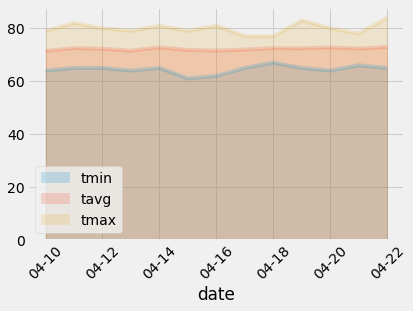

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False,rot=45,alpha=.2);
plt.xlabel("date");

Side Analysis: Precipitation Levels Bar Chart Investigation

In [36]:
# Reading this in again for separate side investigation
inv_prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
inv_prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [37]:
inv_prcp_df.set_index('date',inplace=True)
inv_prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [38]:
inv_prcp_df = inv_prcp_df.sort_index()
inv_prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


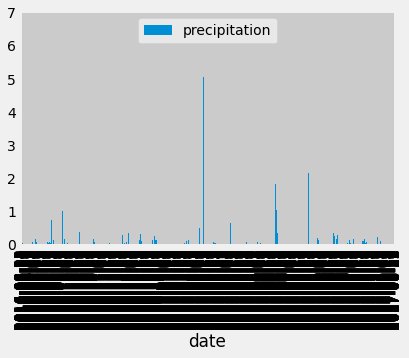

In [41]:
# specifying plot type this time
inv_prcp_df.plot(kind='bar');

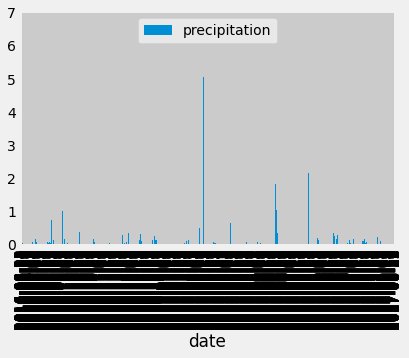

In [42]:
inv_prcp_df.plot(kind='bar', rot=90);

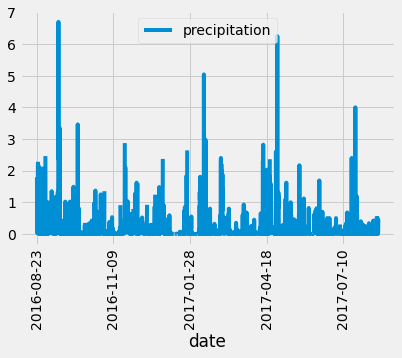

In [43]:
inv_prcp_df.plot(kind='line', rot=90);

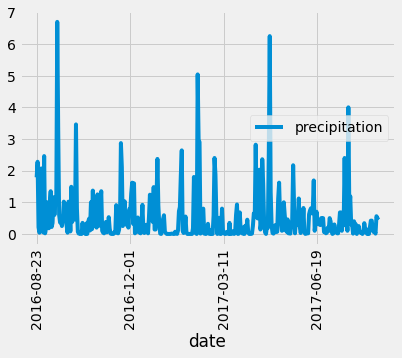

In [44]:
grp_data = inv_prcp_df.reset_index().groupby("date").max()
grp_data.plot(rot=90);


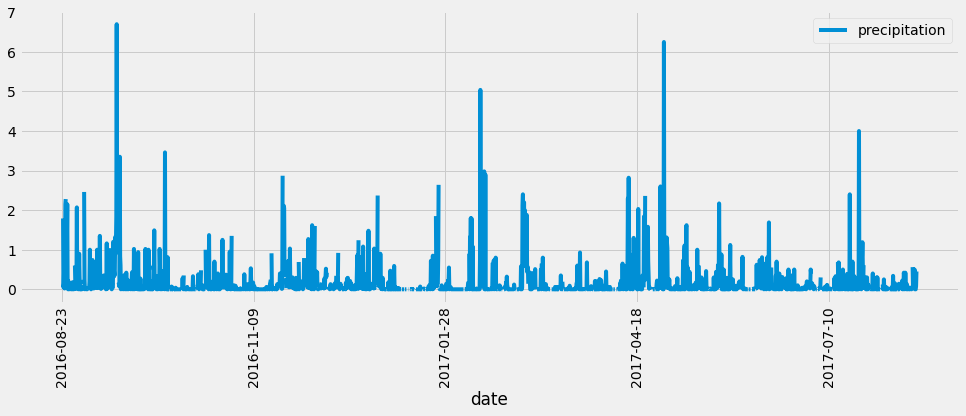

In [45]:
inv_prcp_df.plot(kind='line', rot=90, figsize=(15,5));

To finalize this analysis. it shows different view to plot.There were duplicate values because the station was not included, which caused the data to aggregate in an unintended way, We can find better ways to plot this analysis. I feel this data is all together.A better plot might be to use the different stations and plot their precipitation values over time in separate lines on the same chart. 